# Model training for NFL play prediction

---
 
In this notebook, we train multiple regression and ANN models to predict the yards gained per football play. As a basis we use the preselected data created by the `preprocessing.py``.

### Inline preprocessing steps:

---

As we use 5-fold cross-validation to protect the model against overfitting, we need a dynamic preprocessing appraoch. Therefore a pipeline provided by the `preprocessing.py`` will be used to process the training data of each fold. Further we use a nested cross validation to ensure the quality of our model using selected hyperparameters.


### Contributors

All contributors are only assigned to their primary task, the teams still interchanged know-how and worked on one anothers approaches.

---

##### Preprocessing Team

- Tim Oliver Krause (1689074)
- Jan Thilo Viktorin (1684159)
- Joël Pflomm (1634591)

##### Model Team

- Franziska Köllschen (1981780)
- Steffen Hüls (1979863)
- Matthias Biermanns (1980701)

## Coding

### Coding Foundations

In [ ]:
# basic imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.base import TransformerMixin, BaseEstimator
import preprocessing

# import for data visualization
import matplotlib.pyplot as plt

# imports for regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid

import xgboost as xgb

from subprocess import call
from sklearn.tree import export_graphviz
from IPython.display import Image

In [ ]:
# static variables
FILE_LIST = [f'./Data/play_by_play_{year}.csv' for year in range(1999, 2024)]
PREPROCESSOR = preprocessing.NFLPreprocessing(FILE_LIST)
TARGET_NAME = 'yards_gained'
RANDOM_STATE = 42
LABEL_PASS = 'Pass'
LABEL_RUN = 'Run'

# global variables
model_counter = 0
plot_counter = 0

##### General functions

In [ ]:
def get_sample(df, data_fraction):
    # set fraction between 0 and 1 (e.g. 0.05 -> 5% df)
    df_sampled = df.sample(frac=data_fraction, random_state=RANDOM_STATE)

    # Reset the index if needed
    df_sampled = df_sampled.reset_index(drop=True)

    return df_sampled

def split_feature_target(df):
    features = df.drop(TARGET_NAME, axis=1)
    target = df[TARGET_NAME]

    return features, target

def plot_predicts(y_test, predictions, label):
    # Evaluate the models
    pass_mse = mean_squared_error(y_test, predictions)
    pass_rmse = mean_squared_error(y_test, predictions, squared = False)
    pass_msa = mean_absolute_error(y_test, predictions)

    # Visualize predictions for passes
    plt.scatter(y_test, predictions)
    plt.title(label + ' Model: True vs Predicted Yards')
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()

    print(f"Mean Squared Error: {pass_mse}")
    print(f"Mean Absolute Error: {pass_msa}")
    print(f"Root Mean Squared Error: {pass_rmse}")

def plot_decision_tree(pipeline, label, target_tree=0):
    global plot_counter
    fileName = f'./results/plot_{plot_counter}_{label}_rf'
    # Export the decision tree as a dot file
    export_graphviz(pipeline.named_steps['regressor'].estimators_[target_tree], out_file=f'{fileName}.dot', 
                    feature_names=PREPROCESSOR.get_prepro_feature_names_from_pipeline(),
                    rounded=True, proportion=False, 
                    precision=2, filled=True)

    # Convert the dot file to png using Graphviz (make sure Graphviz is installed)
    call(['dot', '-Tpng', f'{fileName}.dot', '-o', f'{fileName}.png', '-Gdpi=600'])

    plot_counter = plot_counter + 1

    display(Image(filename=f'{fileName}.png'))

def plot_decision_tree_xgb(pipeline, label, target_tree=0):
    global plot_counter
    fileName = f'./results/plot_{plot_counter}_{label}_xgb'

    xgb.plot_tree(pipeline.named_steps['regressor'], num_trees=target_tree)
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
    fig.canvas.manager.set_window_title('Decision Tree for ' + label + ' Model')
    fig.savefig(f'{fileName}.png')
    
    plot_counter = plot_counter + 1

    Image(filename=f'{fileName}.png')

def plot_train_val_loss(training_losses, validation_losses, label):
    global plot_counter
    fileName = f'./results/plot_{plot_counter}_{label}_ann'
    # Plot the training and validation loss
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Neural Network Training and Validation Loss - ' + label)
    plt.legend()
    plt.savefig(f'{fileName}.png')
    plt.show()
    plot_counter = plot_counter + 1

def plot_feature_importances(pipeline, label, show_top_n=10):
    # Get feature importances
    feature_importances = pipeline.named_steps['regressor'].feature_importances_

    # Get the feature names after preprocessing
    columns = PREPROCESSOR.get_prepro_feature_names_from_pipeline()

    # Create a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': columns, 'Importance': feature_importances})

    # Sort the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'][:show_top_n], feature_importance_df['Importance'][:show_top_n])
    plt.xlabel('Importance')
    plt.title(f'Top {show_top_n} Feature Importances - {label}')
    plt.show()

def plot_coef(pipeline):
    coefs = pipeline.named_steps['regressor'].coef_

    # Get the feature names after preprocessing
    columns = PREPROCESSOR.get_prepro_feature_names_from_pipeline()

    coef = pd.DataFrame(coefs, columns=["Coefficients"], index=columns)
    coef.plot(kind="barh", figsize=(9, 7))
    plt.show()

##### Functions for cross validation

In [ ]:
def test_model(pipeline, df, data_fraction: float = None, label = None):
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(data, data_fraction)
    
    features, target = split_feature_target(data)
    X_train, X_test, y_train, y_test = train_test_split(features, target)

    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipeline.predict(X_test)

    plot_predicts(y_test, predictions, label if label else '')
    save_model(features, target, predictions, label, title_appendix=f'normal_{data_fraction*100}%_of_data')

    return y_test, predictions

def test_model_k_fold(df, pipeline, label, k_folds: int=3, data_fraction: float = 1.0):
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(df, data_fraction)
    
    features, target = split_feature_target(data)

    cv_predictions = cross_val_predict(pipeline, features, target, cv=k_folds)
    
    plot_predicts(target, cv_predictions, label)
    save_model(features, target, cv_predictions, label, title_appendix=f'{k_folds}_folds_{data_fraction*100}%_of_data')
    return cv_predictions

def estimate_hyperparams(df, pipeline, scoring, label, k_folds=3, parameters={}, data_fraction: float = 1.0):
    global model_counter
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(df, data_fraction)

    features, target = split_feature_target(data)
    
    # create the grid search instance
    grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=scoring, cv=k_folds, return_train_score=False, n_jobs=1)

    # run the grid search
    grid_search_estimator.fit(features, target)
    
    cv_results_df = pd.DataFrame(grid_search_estimator.cv_results_)
    cv_results_df.to_excel(f'./results/model_{model_counter}_{label}_nestedCV_{data_fraction*100}%_of_data.xlsx')
    display(grid_search_estimator.best_params_)
    display(cv_results_df)

    return grid_search_estimator

def generate_param_combinations(parameters):
    '''list of list required for cross product of two lists'''
    return list(ParameterGrid(parameters))

def save_model(features, target, predictions, label, title_appendix: str = ''):
    global model_counter

    predictions_df = pd.DataFrame({'predicted yards_gained': predictions})
    save_model = pd.concat([features, target, predictions_df], axis=1)

    if (title_appendix != ''):
        title_appendix = '_'+title_appendix
    save_model.to_excel(f'./results/model_{model_counter}_{label}{title_appendix}.xlsx')

    # increase counter for files
    model_counter = model_counter + 1
    pass

##### MLP Regressor Class - with history

In [ ]:
class MLPWithHistory(BaseEstimator, TransformerMixin):
    def __init__(self, mlp_params=None):
        self.mlp_params = mlp_params
        self.training_losses = []
        self.validation_losses = []
        self.mlp_regressor = MLPRegressor(**(self.mlp_params or {}))

    def fit(self, X, y):
        X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        for epoch in range(self.mlp_regressor.max_iter):
            self.mlp_regressor.partial_fit(X, y)

            # Calculate training loss
            y_train_pred = self.mlp_regressor.predict(X)
            training_loss = mean_squared_error(y, y_train_pred)
            self.training_losses.append(training_loss)

            # Calculate validation loss
            y_val_pred = self.mlp_regressor.predict(X_val)
            validation_loss = mean_squared_error(y_val, y_val_pred)
            self.validation_losses.append(validation_loss)

        return self

    def transform(self, X):
        return X

    def predict(self, X):
        return self.mlp_regressor.predict(X)

    def get_params(self, deep=True):
        return {"mlp_params": self.mlp_params}

    def set_params(self, **params):
        self.mlp_params = params["mlp_params"]
        self.mlp_regressor.set_params(**self.mlp_params)
        return self
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_squared_error(y, y_pred)

##### Train and Test Data

In [ ]:
run_df = PREPROCESSOR.run_df
pass_df = PREPROCESSOR.pass_df

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

run_X_train, run_X_test, run_y_train, run_y_test = train_test_split(run_features, run_target)
pass_X_train, pass_X_test, pass_y_train, pass_y_test = train_test_split(pass_features, pass_target)

print(run_features.shape)
print(pass_features.shape)

### Linear Regression

In [ ]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_params = {
    'outlier_remover__kw_args': {
        'strict_factor_iqr': 1.0,
        'loose_factor_iqr': 2.0,
        'strict_columns': ['yardline_100', 'ydstogo'],
        'omit_columns': []
    }
}

pass_params = {
    'outlier_remover__kw_args': {
        'strict_factor_iqr': 1.5,
        'loose_factor_iqr': 3.0,
        'strict_columns': ['ydstogo'],
        'omit_columns': []
    }
}

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_y_test, run_predictions = test_model(pipeline, run_df, 0.05, label=LABEL_RUN)
plot_coef(pipeline)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_y_test, pass_predictions = test_model(pipeline, pass_df, 0.05, label=LABEL_PASS)
plot_coef(pipeline)

In [ ]:
# hyperparameter tuning for linear regression

# could be more over engineered with automatic dict creation if necessary
run_params = {
    'outlier_remover__kw_args': [
        {
            'strict_factor_iqr': 1.0,
            'loose_factor_iqr': 2.0,
            'strict_columns': ['yardline_100', 'ydstogo'],
            'omit_columns': []
        }, {
            'strict_factor_iqr': 1.5,
            'loose_factor_iqr': 3.0,
            'strict_columns': ['yardline_100', 'ydstogo'],
            'omit_columns': []
        },
    ]
}

pass_params = {
    'outlier_remover__kw_args': [{
        'strict_factor_iqr': 1.5,
        'loose_factor_iqr': 3.0,
        'strict_columns': ['ydstogo'],
        'omit_columns': []
    }]
}

pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_grid_search = estimate_hyperparams(run_df, pipeline, 'neg_root_mean_squared_error', parameters=run_params, data_fraction=0.25)
pass_grid_search = estimate_hyperparams(pass_df, pipeline, 'neg_root_mean_squared_error', parameters=pass_params, data_fraction=0.25)

In [ ]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

### Polynomial Regression

In [ ]:
# basic model

# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(2), LinearRegression()))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(2), LinearRegression()))

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05, label=LABEL_RUN)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.05, label=LABEL_PASS)

In [90]:
# make new pipeliness from preprocessing script
poly_pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures()), ('linear_regression', LinearRegression())])
pipeline = PREPROCESSOR.make_preprocessing_pipeline(poly_pipeline)

parameters = {
    'regressor__polynomialfeatures__degree': [2, 3]
}

run_grid_search = estimate_hyperparams(run_df, pipeline, 'neg_root_mean_squared_error', parameters=parameters, data_fraction=0.2)
pass_grid_search = estimate_hyperparams(pass_df, pipeline, 'neg_root_mean_squared_error', parameters=parameters, data_fraction=0.2)

KeyboardInterrupt: 

In [ ]:
# cross-validation with best hyperparameters

# make new pipeliness from preprocessing script
poly_pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures()), ('linear_regression', LinearRegression())])
pipeline = PREPROCESSOR.make_preprocessing_pipeline(poly_pipeline)

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

### KNN

In [ ]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor(n_neighbors=3))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor(n_neighbors=3))

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.2)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.2)

In [ ]:
# estimating hyperparameters
parameters = {
    'regressor__n_neighbors': range(5,10),
    'outlier_remover__kw_args': [
        {
            'strict_columns': ['yardline_100', 'ydstogo', 'score_differential', 'td_prob', 'drive_play_count', 'drive_start_yard_line', 'spread_line', 'total_line', 'overall'],
        },
        {
            'strict_columns': [],
        }
    ]
}

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=1.0)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=1.0)

In [ ]:
# cross-validation with best hyperparameters

# make new pipeliness from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

### Random Forest

2023-12-03 16:18:30.389 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: True
2023-12-03 16:18:30.390 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: ['score_differential', 'drive_play_count', 'spread_line', 'total_line']


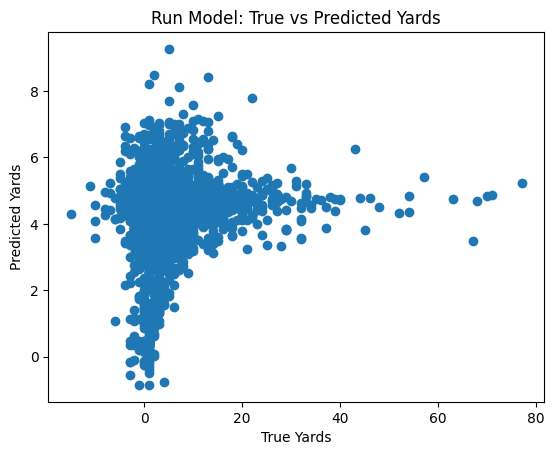

Mean Squared Error: 38.81352196075441
Mean Absolute Error: 3.8243693885584586
Root Mean Squared Error: 6.23004991639348


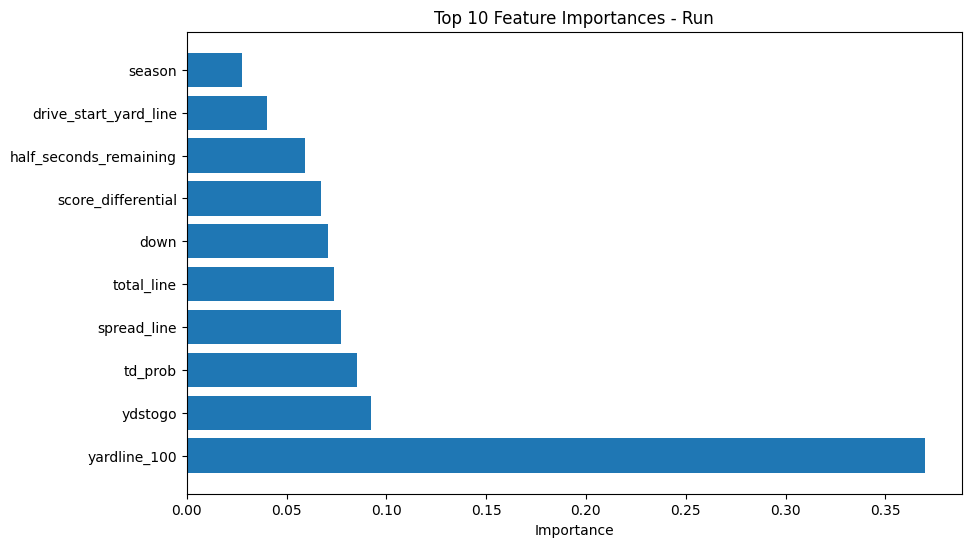

2023-12-03 16:18:36.014 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:36.015 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: ['score_differential', 'drive_play_count', 'spread_line', 'total_line']


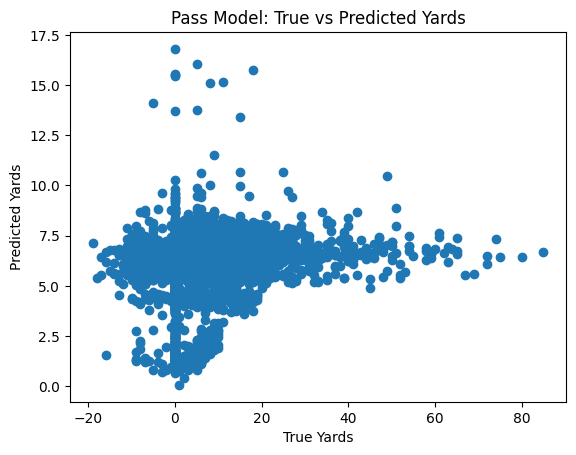

Mean Squared Error: 96.82101978915526
Mean Absolute Error: 6.963721378378812
Root Mean Squared Error: 9.839767262956745


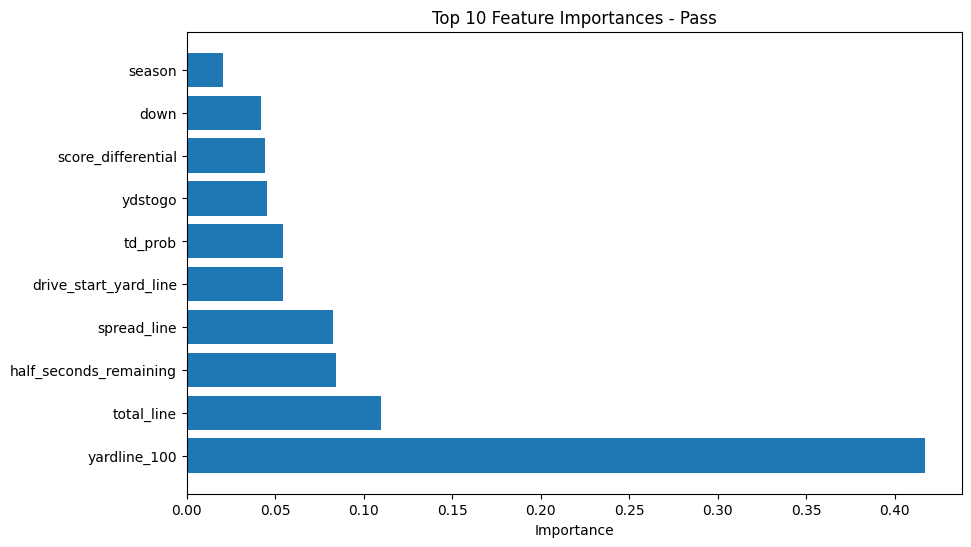

In [19]:
# Basic model
run_params = {
    'outlier_remover__kw_args': {
        'save_stats': True,
    }
}

pass_params = {
    'outlier_remover__kw_args': {
        'save_stats': False,
    }
}

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5))

run_pipeline.set_params(**run_params)
pass_pipeline.set_params(**pass_params)

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05, label=LABEL_RUN)
plot_feature_importances(run_pipeline, LABEL_RUN)

pass_y_test, pass_predictions = test_model(pass_pipeline, pass_df, 0.05, label=LABEL_PASS)
plot_feature_importances(pass_pipeline, LABEL_PASS)

In [20]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())

parameters = {
    'regressor__max_depth': range(4, 6),
    'regressor__n_estimators': [20],
    'outlier_remover__kw_args': [
        {
            'save_stats': False,
        }, {
            'save_stats': True,
        }
    ]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', LABEL_RUN, k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', LABEL_PASS, k_folds=3, parameters=parameters, data_fraction=0.05)

2023-12-03 16:18:43.197 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:43.197 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: ['score_differential', 'drive_play_count', 'spread_line', 'total_line']
2023-12-03 16:18:43.512 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:43.513 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: ['score_differential', 'drive_play_count', 'spread_line', 'total_line']
2023-12-03 16:18:43.823 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:43.824 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: ['score_differential', 'drive_play_count', 'spread_line', 'total_line']
2023-12-03 16:18:44.139 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:44.139 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: 

{'outlier_remover__kw_args': {'save_stats': False},
 'regressor__max_depth': 4,
 'regressor__n_estimators': 20}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.252728,0.002876,0.008334,0.000471,{'save_stats': False},4,20,{'outlier_remover__kw_args': {'save_stats': Fa...,-6.467873,-6.202224,-6.257489,-6.309195,0.114448,1
1,0.310344,0.006818,0.009171,0.000241,{'save_stats': False},5,20,{'outlier_remover__kw_args': {'save_stats': Fa...,-6.471176,-6.220806,-6.263636,-6.318539,0.109338,4
2,0.308544,0.052263,0.008121,0.000170,{'save_stats': True},4,20,{'outlier_remover__kw_args': {'save_stats': Tr...,-6.470450,-6.214405,-6.261423,-6.315426,0.111286,2
3,0.327117,0.006439,0.008651,0.000461,{'save_stats': True},5,20,{'outlier_remover__kw_args': {'save_stats': Tr...,-6.468660,-6.219600,-6.259807,-6.316022,0.109172,3


2023-12-03 16:18:48.140 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:48.141 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: ['score_differential', 'drive_play_count', 'spread_line', 'total_line']
2023-12-03 16:18:48.527 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:48.527 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: ['score_differential', 'drive_play_count', 'spread_line', 'total_line']
2023-12-03 16:18:48.906 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:48.906 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: ['score_differential', 'drive_play_count', 'spread_line', 'total_line']
2023-12-03 16:18:49.275 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:49.276 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: 

{'outlier_remover__kw_args': {'save_stats': True},
 'regressor__max_depth': 4,
 'regressor__n_estimators': 20}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.314295,0.005906,0.010333,0.000471,{'save_stats': False},4,20,{'outlier_remover__kw_args': {'save_stats': Fa...,-10.060059,-9.739425,-10.033861,-9.944448,0.145367,2
1,0.431185,0.068281,0.010978,0.000789,{'save_stats': False},5,20,{'outlier_remover__kw_args': {'save_stats': Fa...,-10.069538,-9.747973,-10.036076,-9.951196,0.144348,4
2,0.334184,0.006735,0.010000,0.000817,{'save_stats': True},4,20,{'outlier_remover__kw_args': {'save_stats': Tr...,-10.058960,-9.732415,-10.031529,-9.940968,0.147894,1
3,0.396393,0.003928,0.010504,0.000410,{'save_stats': True},5,20,{'outlier_remover__kw_args': {'save_stats': Tr...,-10.069000,-9.736067,-10.036404,-9.947157,0.149855,3


In [ ]:
# cross-validation with best hyperparameters

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

# make new pipeliness from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

In [ ]:
# Plot the decision tree for passes
plot_decision_tree(run_pipeline, LABEL_PASS)

# Plot the decision tree for runs
plot_decision_tree(pass_pipeline, LABEL_RUN)

### XGBoost

In [ ]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    xgb.XGBRegressor(
        learning_rate = 0.022,
        n_estimators  = 1000,
        max_depth     = 8,
        eval_metric='rmsle'
                           )
)
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    xgb.XGBRegressor(
        learning_rate = 0.015,
        n_estimators  = 1000,
        max_depth     = 8,
        eval_metric='rmsle'
        )
)

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.05)

plot_feature_importances(run_pipeline, LABEL_RUN)
plot_feature_importances(pass_pipeline, LABEL_PASS)

In [ ]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())

parameters = {
    "regressor__max_depth":    [8, 10],
    "regressor__n_estimators": [1000, 1100],
    "regressor__learning_rate": [0.022, 0.015]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)

In [ ]:
pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

In [ ]:
# Plot the decision tree for passes
plot_decision_tree_xgb(run_pipeline, LABEL_PASS)

# Plot the decision tree for runs
plot_decision_tree_xgb(pass_pipeline, LABEL_RUN)

### Artificial Neuronal Network

In [ ]:
# Basic model

run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    MLPWithHistory(
        mlp_params={'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}
    )
)
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    MLPWithHistory(
        mlp_params={'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}
    )
)

# estimate run model
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.2)
run_mlp = run_pipeline.named_steps['regressor']
plot_train_val_loss(run_mlp.training_losses, run_mlp.validation_losses, LABEL_RUN)

# estimate pass model
pass_y_test, pass_predictions = test_model(pass_pipeline, pass_df, 0.2)
pass_mlp = pass_pipeline.named_steps['regressor']
plot_train_val_loss(pass_mlp.training_losses, pass_mlp.validation_losses, LABEL_PASS)

In [ ]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())

parameters = {
    'regressor__mlp_params': generate_param_combinations({
        'hidden_layer_sizes': [(10,), (50,), (10,5), (20,10)], 
        'activation': ['relu'], 
        'solver': ['adam'], 
        'max_iter': [100] 
    })
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)

In [ ]:
pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)